In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lib.residental_data_source import ResidentialDataSource
from sklearn.preprocessing import StandardScaler

In [163]:
data_source = ResidentialDataSource('src/dataset_processed.xlsx')
ds = data_source.fetch_data_set()
ds.head()

,Таргет,Всероссийский застройщик,Инфраструктура: Рядом ВУЗ,Есть железная дорога 250м,Есть ЛЭП 100м,Есть магистральные дороги 100м,Есть АЗС 100м,Есть скверы 500м,Есть лес 500м,Есть водоем 500м,...,Месяц_6,Месяц_7,Месяц_8,Месяц_9,Тип дома_другой,Тип дома_монолит,Тип дома_монолитный каркас,Тип дома_панель,Статус_сдан,Статус_строится
0,95000.000000,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,105683.431953,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,110317.929760,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,115389.053254,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,132843.750000,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


## Линейная регрессия

In [164]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score

In [165]:
X = ds.drop(columns=['Таргет']) 
y = ds['Таргет']   

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [167]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

wape = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test))

print('Значения метрик:')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'WAPE: {wape}')

cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
mean_cv_score = np.mean(-cv_scores)

print(f'Средний MAE по кросс-валидации: {mean_cv_score}')

Значения метрик:
MAE: 1948205424655.9668
MSE: 1.1690153343954871e+27
WAPE: 13941936.438864013
Средний MAE по кросс-валидации: 2.6139865587593773e+17


In [168]:
y_test.describe()

count       308.000000
mean     139737.075492
std       32409.125742
min       63323.365412
25%      119385.926701
50%      134895.661157
75%      154776.032956
max      286000.000000
Name: Таргет, dtype: float64

## Ridge model

In [169]:
from sklearn.linear_model import Ridge

In [170]:
ds = data_source.fetch_data_set()
X = ds.drop(columns=['Таргет'])
y = ds['Таргет']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=70)

In [172]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [173]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

Ridge()

In [174]:
y_pred = ridge.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

Mean Squared Error: 302106144.1217
Mean Absolute Error: 12174.4917


In [175]:
wape = 100 * (sum(abs(y_test - y_pred)) / sum(abs(y_test)))
print(f'WAPE: {wape:.2f}%')

WAPE: 8.64%


## Решающие деревья

In [176]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz

In [177]:
ds = data_source.fetch_data_set()


In [178]:
data = pd.concat([X, y], axis=1)
data = data.dropna()

X = data.drop(columns=['Таргет'])
y = data['Таргет']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [179]:
# масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [180]:
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train_scaled, y_train)

y_pred = regressor.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')

wape = 100 * (sum(abs(y_test - y_pred)) / sum(abs(y_test)))
print(f'WAPE: {wape:.2f}%')

Mean Squared Error: 433507464.7780
WAPE: 10.15%


In [181]:
# dot_data = export_graphviz(regressor, out_file=None, 
#                            feature_names=X.columns,  
#                            filled=True, rounded=True,  
#                            special_characters=True)  
# graph = graphviz.Source(dot_data)  
# graph.render("decision_tree", format='png', view=True, cleanup=True)
# graph.view()

## Gradient boosting

In [182]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [183]:
ds = data_source.fetch_data_set()
X = ds.drop(columns=['Таргет'])
y = ds['Таргет']

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [186]:
gbrt = GradientBoostingRegressor(random_state=42)
gbrt.fit(X_train_scaled, y_train)

y_pred = gbrt.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')

wape = 100 * (sum(abs(y_test - y_pred)) / sum(abs(y_test)))
print(f'WAPE: {wape:.2f}%')

Mean Squared Error: 222716773.5373
Mean Absolute Error: 11089.9452
R-squared: 0.7562
WAPE: 7.79%


In [187]:
feature_importances = gbrt.feature_importances_
print(f'Feature Importances:\n{feature_importances}')

feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})


Feature Importances:
[5.20711951e-03 0.00000000e+00 8.71513839e-02 7.17246033e-04
 1.43337660e-04 9.37916334e-04 1.01404366e-04 3.10011532e-05
 0.00000000e+00 2.35028530e-04 0.00000000e+00 0.00000000e+00
 1.39963215e-02 0.00000000e+00 0.00000000e+00 4.85028837e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.23081871e-03 0.00000000e+00 2.24982815e-02 1.07252918e-03
 0.00000000e+00 6.94204619e-04 7.07793481e-03 0.00000000e+00
 1.76143589e-01 2.60938350e-02 1.22869109e-01 0.00000000e+00
 3.74519104e-02 4.06346356e-04 9.41013465e-04 5.48275789e-03
 2.12312761e-04 4.57760416e-03 8.14795008e-03 0.00000000e+00
 1.09675323e-03 0.00000000e+00 1.19289055e-03 4.53057654e-04
 3.16366242e-04 9.20452343e-04 9.79876329e-04 4.46106777e-02
 2.57349813e-03 8.36495697e-03 2.61829427e-05 0.00000000e+00
 2.69417357e-03 5.91762120e-03 7.72382271e-05 2.33476444e-02
 9.95527186e-04 8.18633624e-04 2.33351886e-02 2.85518488e-03
 3.90303702e-03 1.04361459e-03 2.15639114e-04 3.74784668e-02
 2.

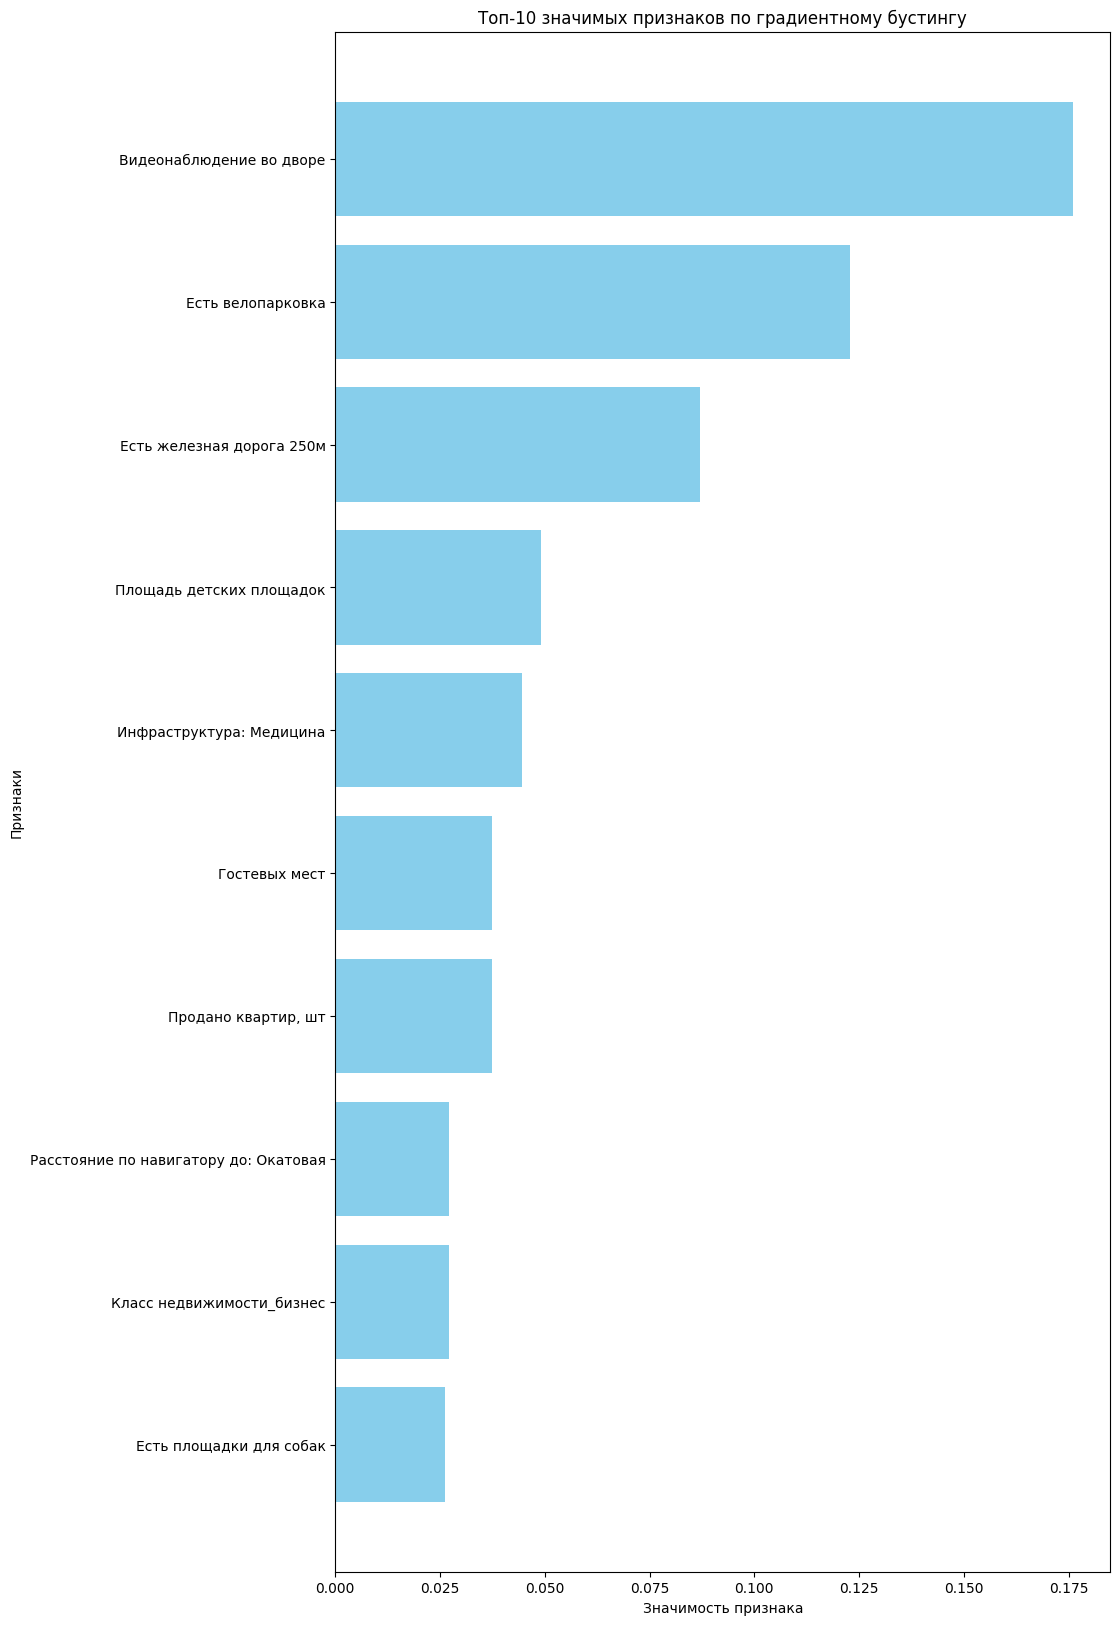

In [188]:
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Значимость признака')
plt.ylabel('Признаки')
plt.title('Топ-10 значимых признаков по градиентному бустингу')
plt.gca().invert_yaxis() 
plt.show()
